# **Detect Hallucination in RAG**

Authored by [Kalyan KS](https://www.linkedin.com/in/kalyanksnlp/). To stay updated with LLMs, RAG and Agents, you can follow him on [LinkedIn](https://www.linkedin.com/in/kalyanksnlp/), [Twitter](https://x.com/kalyan_kpl) and [YouTube](https://youtube.com/@kalyanksnlp?si=ZdoC0WPN9TmAOvKB).


## **Overview**

1. Large Language Models (LLMs) have advanced significantly but face challenges in real-world use due to hallucinations.

2. Hallucinations are LLM generated responses that are factually incorrect.

3. Retrieval-Augmented Generation (RAG) enhances LLMs by providing relevant context from external knowledge sources.

4. RAG helps to reduce hallucinations, yet LLMs still experience them even with added context.


## **Detect hallucination in RAG using LLMs**

In [ ]:
!pip install langchain langchain-openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 420.1/420.1 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 36.8 MB/s eta 0:00:00
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.47
    Uninstalling langchain-core-0.3.47:
      Successfully uninstalled langchain-core-0.3.47


In [ ]:
from google.colab import userdata
import os
os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')

In [ ]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import PydanticOutputParser
from pydantic import BaseModel, Field
import os

In [ ]:
# Set up the LLM
llm = ChatOpenAI(model="gpt-4o", temperature=0)

In [ ]:
# Pydantic model for structured outputs
class HallucinationResult(BaseModel):
    hallucination_detected: bool = Field(description="Whether a hallucination was detected in the answer")
    hallucinated_text_span: str = Field(description="The specific text in the answer that contains the hallucination, or empty string if none")
    details: str = Field(description="Explanation of why the answer is considered a hallucination or why it is correct")

output_parser = PydanticOutputParser(pydantic_object=HallucinationResult)

In [ ]:
# Hallucination detection prompt
chat_prompt = ChatPromptTemplate.from_template(
    """You are an expert fact-checker tasked with detecting hallucinations (inaccurate or unsupported information) in answers based on provided context and question. A hallucination occurs when the answer contains information that contradicts the context, is not supported by it, or introduces extraneous details not asked for by the question.

Context: {context}
Question: {question}
Answer: {answer}

Your task is to:
1. Compare the answer to the context and question.
2. Identify any specific text spans in the answer that are hallucinatory (inaccurate or unsupported).
3. Provide a detailed explanation of your findings.
4. Return the result in the following structured JSON format, adhering to the schema below.


Please analyze the answer for hallucinations and provide the result in the requested format.
{format_instructions}
"""
)

# Hallucination detection chain
hallucination_detector = chat_prompt | llm | output_parser


In [ ]:
# Define context, question and answer.
context = "France is a country in Europe. The capital of France is Paris. The population of France is 67 million."
question = "What is the capital of France? What is the population of France?"
answer = "The capital of France is Paris. The population of France is 69 million."


# Run the chain to get the hallucinated text spans
result = hallucination_detector.invoke({
    "context": context,
    "question": question,
    "answer": answer,
    "format_instructions": output_parser.get_format_instructions()
})

# Display the results
print(f"Hallucination Detected: {result.hallucination_detected}")
print(f"Hallucinated Text Span: '{result.hallucinated_text_span}'")
print(f"Details: {result.details}")

Hallucination Detected: True
Hallucinated Text Span: 'The population of France is 69 million.'
Details: The context states that the population of France is 67 million, but the answer incorrectly states it as 69 million. This discrepancy indicates a hallucination in the answer.


## **Detect hallucination in RAG using LettuceDetect**

1. We can use LettuceDetect, a novel framework to detect hallucination in RAG.

2. LettuceDetect framework approaches the task of hallucination detection as a token classification problem.

3. Based on the retrieved context and user question, the framework detects the hallucinated text in the generated response.







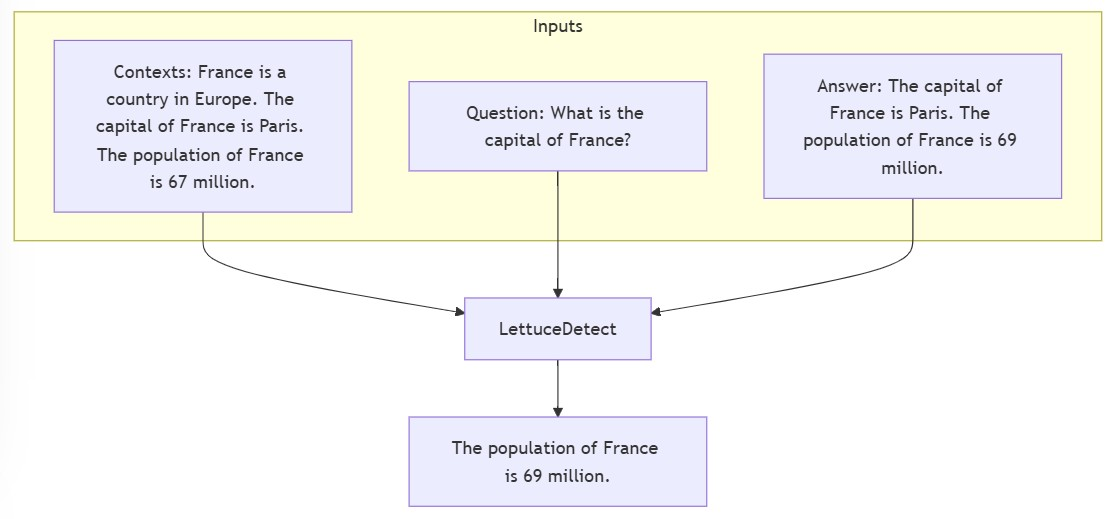

### **LettuceDetect Framework**

1. LettuceDetect framework leverages ModernBERT model fine-tuned over RAGTruth dataset.

2. LettuceDetect addresses two critical limitations in existing hallucination detection methods:
    -  the context window constraints of traditional encoder-based methods, and
    - the computational inefficiency of LLM-based approaches.

3. LettuceDetect outperforms all previous encoder-based models and most prompt-based models, while being approximately 30 times smaller than the best models.

4. Importantly,  LettuceDetect can process 30 to 60 examples per second on a single GPU, making it more practical for real-world RAG applications.

5. LettuceDetect offers two models namely
     - lettucedetect-base: https://huggingface.co/KRLabsOrg/lettucedect-base-modernbert-en-v1
     - lettucedetect-large: https://huggingface.co/KRLabsOrg/lettucedect-large-modernbert-en-v1

### **Implementation**

**Note** - lettucedetect requires CUDA 11.8

In [ ]:
# Uninstall existing torchvision
!pip uninstall torchvision -y

# Install PyTorch and compatible torchvision with CUDA 11.8 support
!pip install --upgrade torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

# Install lettucedetect library
!pip install lettucedetect

Found existing installation: torchvision 0.21.0+cu124
Uninstalling torchvision-0.21.0+cu124:
  Successfully uninstalled torchvision-0.21.0+cu124
Looking in indexes: https://download.pytorch.org/whl/cu118
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 58.5 MB/s eta 0:00:00


In [ ]:
from lettucedetect.models.inference import HallucinationDetector

# Initialize the HallucinationDetector with specific parameters
# - method="transformer": specifies to use transformer-based detection
# - model_path: specifies the pre-trained model to use
detector = HallucinationDetector(
    method="transformer", model_path="KRLabsOrg/lettucedect-base-modernbert-en-v1"
)

# Define contexts, question and answer
contexts = ["France is a country in Europe. The capital of France is Paris. The population of France is 67 million.",]
question = "What is the capital of France? What is the population of France?"
answer = "The capital of France is Paris. The population of France is 69 million."

# Run the predict() to detect potential hallucinations
# - context: the factual background information
# - question: the query being answered
# - answer: the response to evaluate
# - output_format="spans": return results as text spans
predictions = detector.predict(context=contexts, question=question, answer=answer, output_format="spans")

model.safetensors:   0%|          | 0.00/598M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/lettucedetect/models/inference.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, device=self.device)
Compiling the model with `torch.compile` and using a `torch.cpu` device is not supported. Falling back to non-compiled mode.


In [ ]:
# Display the hallucinated text span
print(f"Hallucinated text: {predictions[0]['text']}")

Hallucinated text:  The population of France is 69 million.
